<h1><center>IE 313 Time Series Analysis: Code Implementation Assignment 2</center></h1>

<div align="right">2023 Fall, Nguyen Minh Duc (ID: 20202026)</div>
<div align="right">Modified from Prof.Sungil Kim's code</div>

Install the required packages using pip
* Install using pip : `pandas`, `sklearn`, `matplotlib`, `statsmodels`
* This code was developed in Python 3.8 and any other versions are allowed.

In [1]:
import numpy as np  #for numeric computations like log, exp, sqrt
import pandas as pd #for reading & storing data, pre=processing
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt #for visualization
import statsmodels.api as sm
from scipy import stats
from tqdm import tqdm
import seaborn as sns

## Read Data

Read '.csv' file in the form of DataFrame (pandas.DataFrame) through 'read_csv' method in Pandas. 

* Else, read using 'read_excel' method. 
* In this example, daily closing price of APPLE Inc. was used.
* If there is 'Date' column, indexing is possible by specifying 'index_col' as below.

In [2]:
# use your own data
data = pd.read_csv('currency-krw-vnd.csv', index_col='Date')


It is convenient to change Date dtype from 'object' to 'datetime'.

In [3]:
# check index type
data.index

Index(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',
       '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
       ...
       '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25', '2022-12-26',
       '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30', '2022-12-31'],
      dtype='object', name='Date', length=1095)


Convert index type using 'pd.to_datetime' method.

In [4]:
# convert index type to datetime
data.index = pd.to_datetime(data.index)

In [5]:
# Check that dtype has changed to datetime
data.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='Date', length=1095, freq=None)

## Data Overview

In [6]:
data

,Close
Date,
2020-01-01,20.044639
2020-01-02,20.019871
2020-01-03,19.871531
2020-01-04,19.874437
2020-01-05,19.874437
...,...
2022-12-27,18.544642
2022-12-28,18.543146
2022-12-29,18.736217



Visualize your data using matplotlib

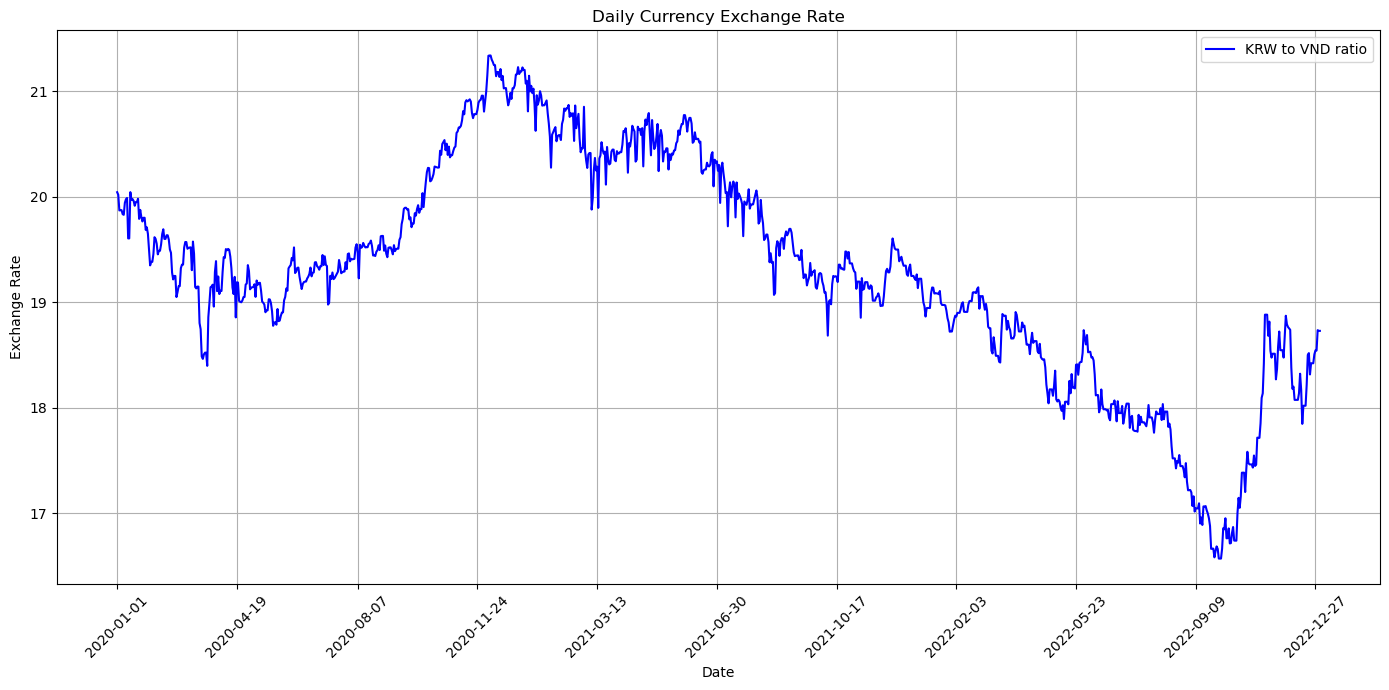

In [7]:
# Plotting the data
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='KRW to VND ratio', color='blue')
plt.title('Daily Currency Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.xticks(data.index[::int(len(data)/10)], rotation=45)  # Displaying every nth date label for clarity
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Plot Scatter

The figure below is a scatter plot in the textbook, and draw a graph to examine the relationship with the previous points.

![](https://trello.com/1/cards/62469d0f1dfc968cf7510f2b/attachments/63183fcc8ab03000373d8d61/previews/63183fcc8ab03000373d8d69/download/image.png)


Shift your data by one time step interval through 'shift(1)' and draw a scatter plot.

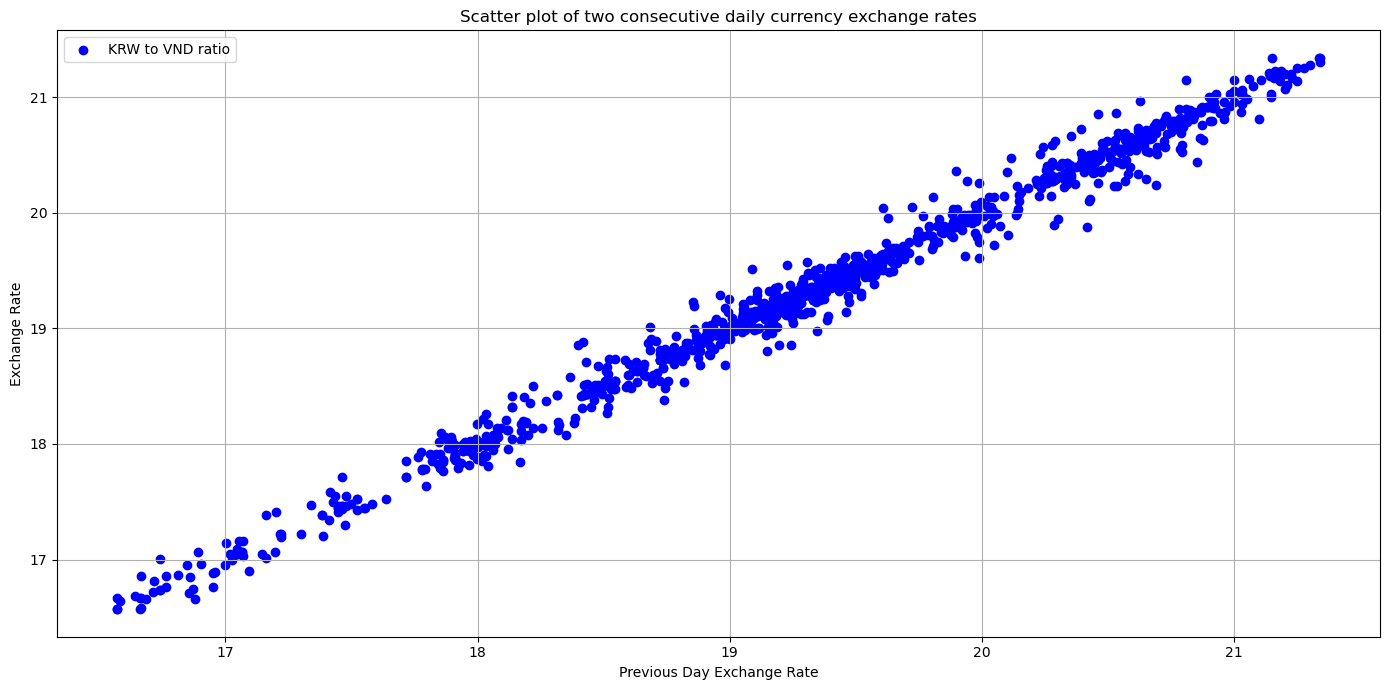

In [8]:
shift_amount = 1
# Plotting the data
plt.figure(figsize=(14, 7))
plt.scatter(data.shift(shift_amount)[shift_amount:], data[shift_amount:], label='KRW to VND ratio', color='blue')
plt.title('Scatter plot of two consecutive daily currency exchange rates')
plt.xlabel('Previous Day Exchange Rate')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Resample Data

Follow this part if you need to resample your data.

Set a different period using the `resample` (In this example,the period is changed from daily to monthly).

In [9]:
# monthly_data = data.resample('M').first() # resample with closing price on the first trading day of the month 
# monthly_data = data.resample('M').mean() # resample with monthly average closing price
monthly_data = data.resample('M').last() # resample with closing price on the last trading day of the month 

In [10]:
monthly_data.head()

,Close
Date,
2020-01-31,19.350583
2020-02-29,19.357806
2020-03-31,19.390970
2020-04-30,19.296266
2020-05-31,18.905467


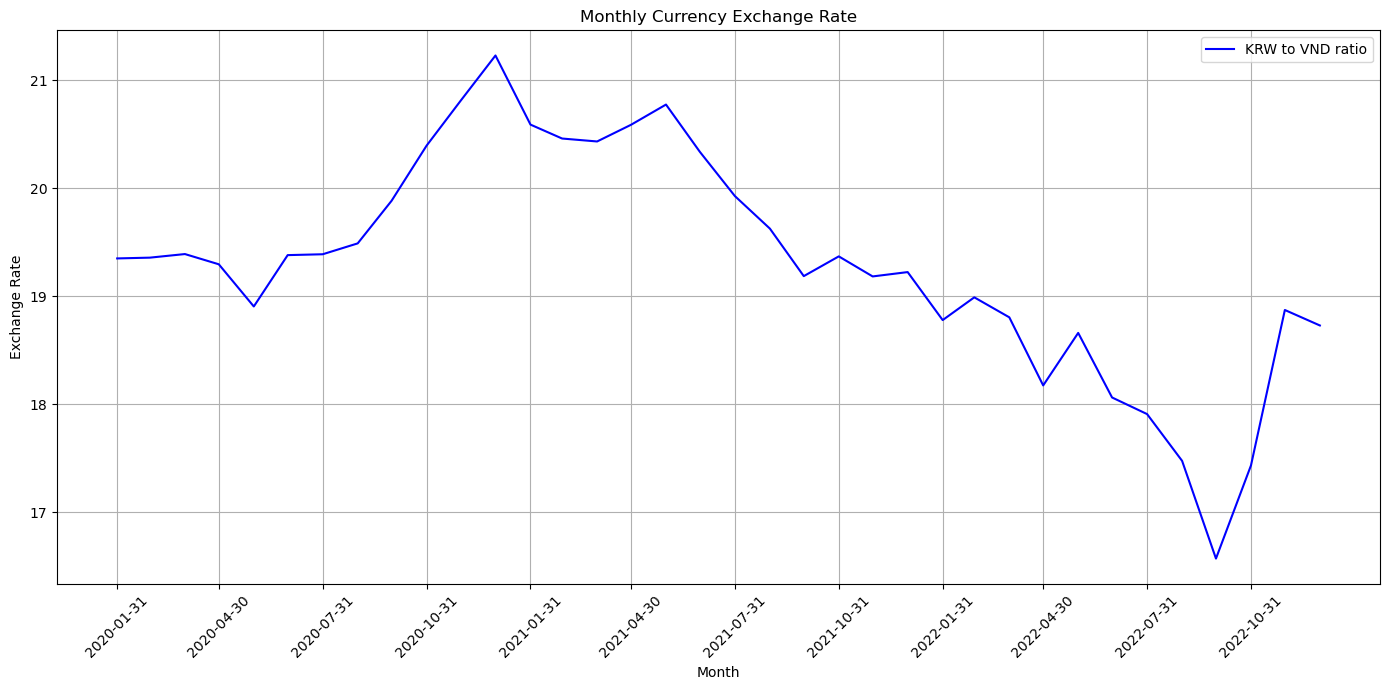

In [11]:
# Plotting the monthly data
plt.figure(figsize=(14, 7))
plt.plot(monthly_data.index, monthly_data['Close'], label='KRW to VND ratio', color='blue')
plt.title('Monthly Currency Exchange Rate')
plt.xlabel('Month')
plt.ylabel('Exchange Rate')
plt.xticks(monthly_data.index[::int(len(monthly_data)/10)], rotation=45)  # Displaying every nth date label for clarity
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

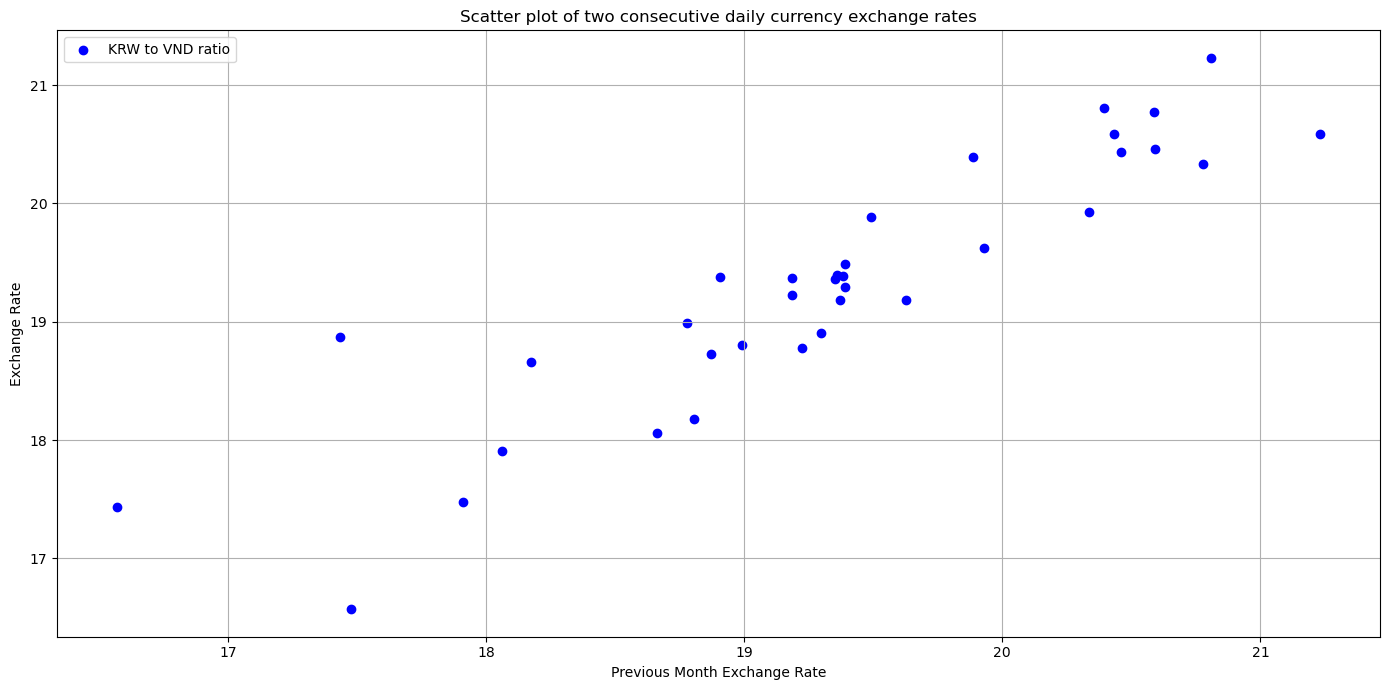

In [12]:
shift_amount = 1
# Plotting the data
plt.figure(figsize=(14, 7))
plt.scatter(monthly_data.shift(shift_amount)[shift_amount:], monthly_data[shift_amount:], label='KRW to VND ratio', color='blue')
plt.title('Scatter plot of two consecutive daily currency exchange rates')
plt.xlabel('Previous Month Exchange Rate')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Define Variables

Set x so that can represent time as the length of data.


In [13]:
x = np.arange(len(data))

Set y as the target of your analysis.

In [14]:
# y = data.values.reshape(-1,1)
y = data.values

## Curve Fitting

We are going to fit regression by adding trigonometric functionsto match the data as shown below.

$$y=w_0+w_1x+w_2x^2 + w_3\sin\left(2\pi f_1x\right) + w_4\sin\left(2\pi f_2x\right)$$

$$y=\begin{bmatrix}
w_0 & w_1 & w_2 & w_3 & w_4 \end{bmatrix}\begin{bmatrix}
1\\
x\\
x^2\\
\sin\left(2\pi f_1x\right)\\
\sin\left(2\pi f_2x\right)
\end{bmatrix} = \mathbf{w}\mathbf{x}$$



In the case of model which contains linear, quadratic, and sine trends, set x as shown below.

* $f_1$, and $f_2$, which are related to frequency in sine trends, should be set in advance. 

### Grid Search

We can find the best performing frequencies by doing a grid search. For simplicity, let's assume the frequencies have the form of $\frac{(365k)^{-1}}{2\pi}$

In [15]:
best_r2 = 0
best_f1 = 0
best_f2 = 0
for f1 in tqdm(np.linspace(0.01, 2, 200)):
    for f2 in np.linspace(0.01, 2, 200):
        X = np.column_stack((np.ones(len(x)), x, x ** 2,
                            np.sin(2* np.pi * 1 / (365 * f1) / (2*np.pi)*x), np.sin(2* np.pi * 1 / (365 * f2) / (2*np.pi)*x)))
        curve_reg = sm.OLS(y, X).fit()
        # print(f"{curve_reg.rsquared:.3f}({f1:.3f}, {f2:.3f})", end=' ')
        if best_r2 < curve_reg.rsquared:
            best_r2 = curve_reg.rsquared
            best_f1 = f1
            best_f2 = f2
    # print()

100%|██████████| 200/200 [00:16<00:00, 12.27it/s]


In [16]:
print(f"Best r^2: {best_r2:.3f}")
print(f"Best f_1: {best_f1:.2f}")
print(f"Best f_2: {best_f2:.2f}")

Best r^2: 0.925
Best f_1: 0.21
Best f_2: 0.89


In our case, the best frequencies are
$$ \begin{cases}
f_1 &= \dfrac{(365 \times 0.21)^{-1}}{2\pi}\\
\\
f_2 &= \dfrac{(365 \times 0.89)^{-1}}{2\pi}
\end{cases}$$

### Fitting Curve Regression with the best frequencies

Generate  $\mathbf{x}$ using `np.columns_stack` .

In [17]:
X = np.column_stack((np.ones(len(x)), x, x ** 2,
                     np.sin(2* np.pi * 1 / (365 * best_f1) / (2*np.pi)*x), np.sin(2* np.pi * 1 / (365 * best_f2) / (2*np.pi)*x)))

In [18]:
curve_reg = sm.OLS(y, X).fit()
print(curve_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     3361.
Date:                Wed, 11 Oct 2023   Prob (F-statistic):               0.00
Time:                        11:11:52   Log-Likelihood:                -188.38
No. Observations:                1095   AIC:                             386.8
Df Residuals:                    1090   BIC:                             411.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.2384      0.033    615.768      0.0

In [19]:
print("Residual standard error: ", np.std(curve_reg.resid, ddof=1))

Residual standard error:  0.2875261131783775


### Model's parameters

In [20]:
print("Parameters: ", curve_reg.params) # parameter w

Parameters:  [ 2.02384337e+01 -7.94402351e-02  7.55847789e-05 -4.73474162e-01
  2.11347890e+01]


### Visualization

In [21]:
y_pred = curve_reg.predict(X)

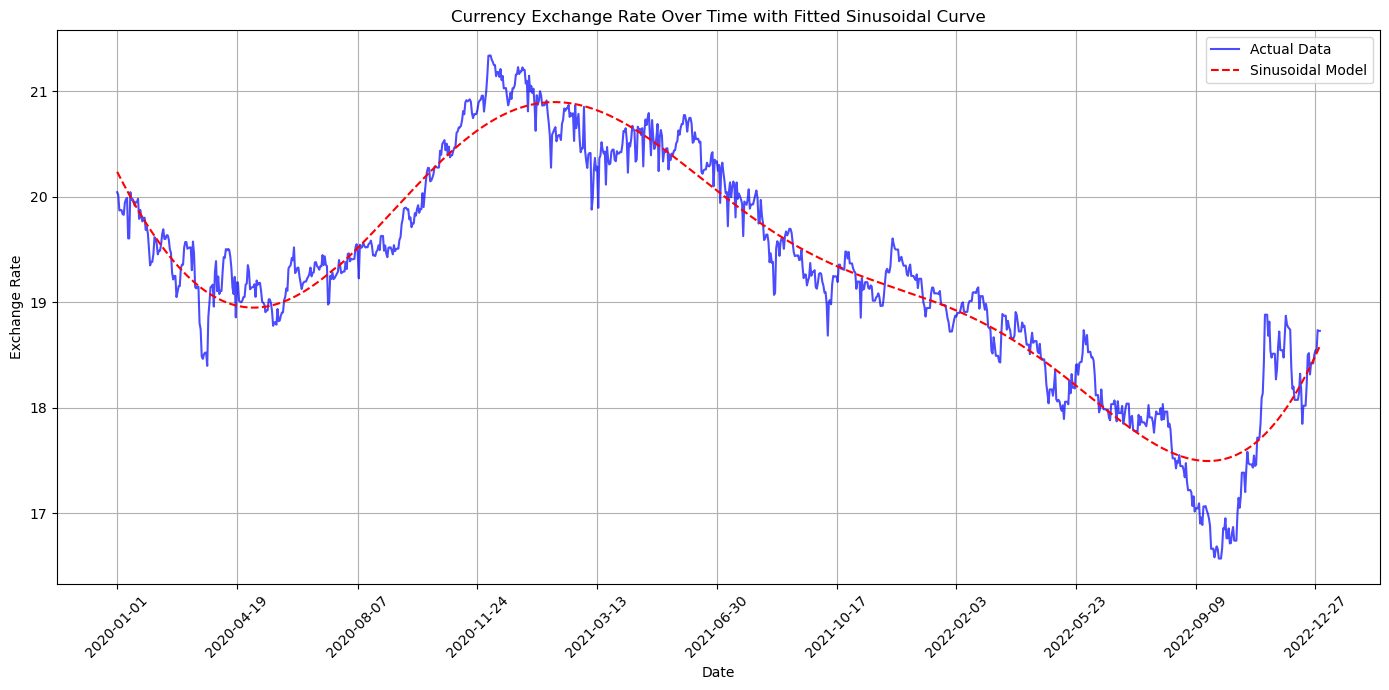

In [22]:
# Plotting the actual data along with modified sinusoidal model predictions with an additional sinusoidal term
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Actual Data', color='blue', alpha=0.7)
plt.plot(data.index, y_pred, label='Sinusoidal Model', linestyle='--', color='red')
# plt.plot(data.index, y_pred_sincos_double_sincos, label='Combined Sin-Cos Model with Quadratic & Additional Sin-Cos Terms', linestyle='--', color='green')
plt.title('Currency Exchange Rate Over Time with Fitted Sinusoidal Curve')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.xticks(data.index[::int(len(data)/10)], rotation=45)  # Displaying every nth date label for clarity
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Residual Analysis

Follow this part to practice with your data.

$$\text{Residual}=y_t - \hat{y}_t$$

Calculate the residual using `lin_reg.resid` method.

In [23]:
residual = curve_reg.resid

This residual is not standardized.

In [24]:
residual

array([-0.19379477, -0.19808072, -0.32609156, ...,  0.19642371,
        0.16680816,  0.14356311])

`s_residual`: Standardized Residual

In [25]:
def standardized(array_like):
    mean = array_like.mean()
    std = array_like.std(ddof=1)
    return pd.Series((array_like - mean) / std)

In [26]:
s_residual = standardized(residual)

### Plot Standardized Residuals

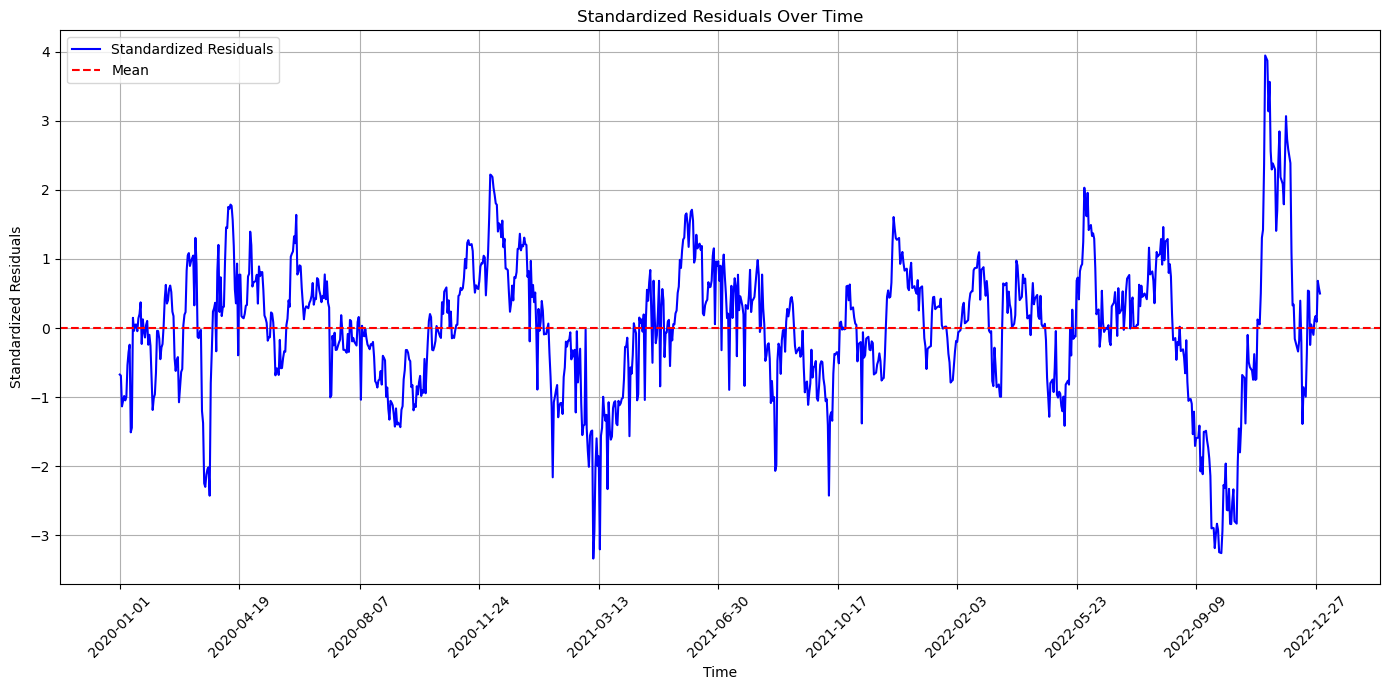

In [27]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, s_residual, label='Standardized Residuals', color='blue')
plt.axhline(np.mean(s_residual), color='red', linestyle='--', label="Mean")
plt.title('Standardized Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Standardized Residuals')
plt.xticks(data.index[::int(len(data)/10)], rotation=45)  # Displaying every nth date label for clarity
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Histogram of Standardized Residuals

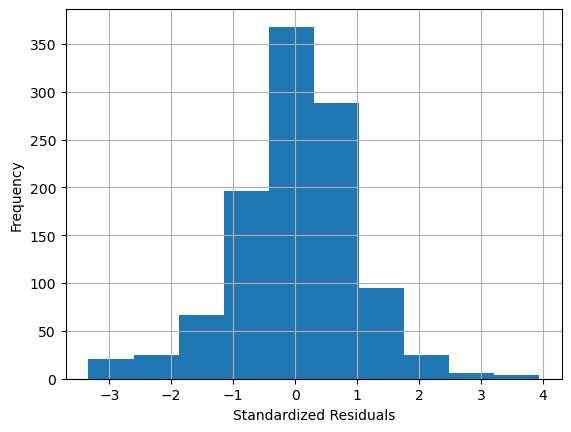

In [28]:
s_residual.hist();
plt.xlabel('Standardized Residuals')
plt.ylabel('Frequency');

You can notice that the residual does follow the normal distribution

### Q-Q Plot

There is another method to visualize normality, Q-Q plot.

Plot with the scipy `probplot` function.

If you put the normal distribution in the dist as shown below, and if the dots are distributed along the red line, it means that the residual is close to the normal distribution.

In this example, it seems to follow the normal distribution but it is right-skew

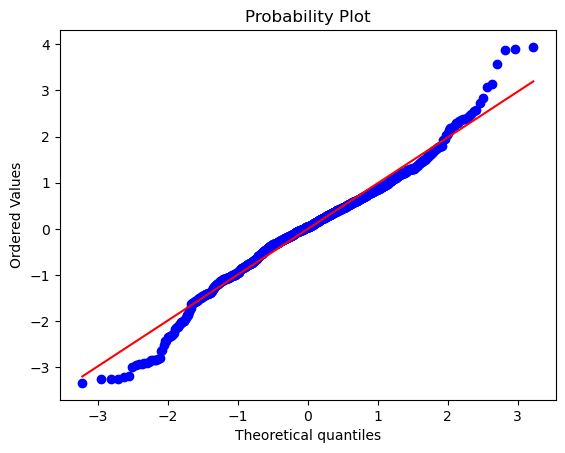

In [29]:
stats.probplot(s_residual, dist=stats.norm, plot=plt);

### Side-by-side Histogram and Q-Q Plot graphs

Text(0, 0.5, 'Sample Quantiles')

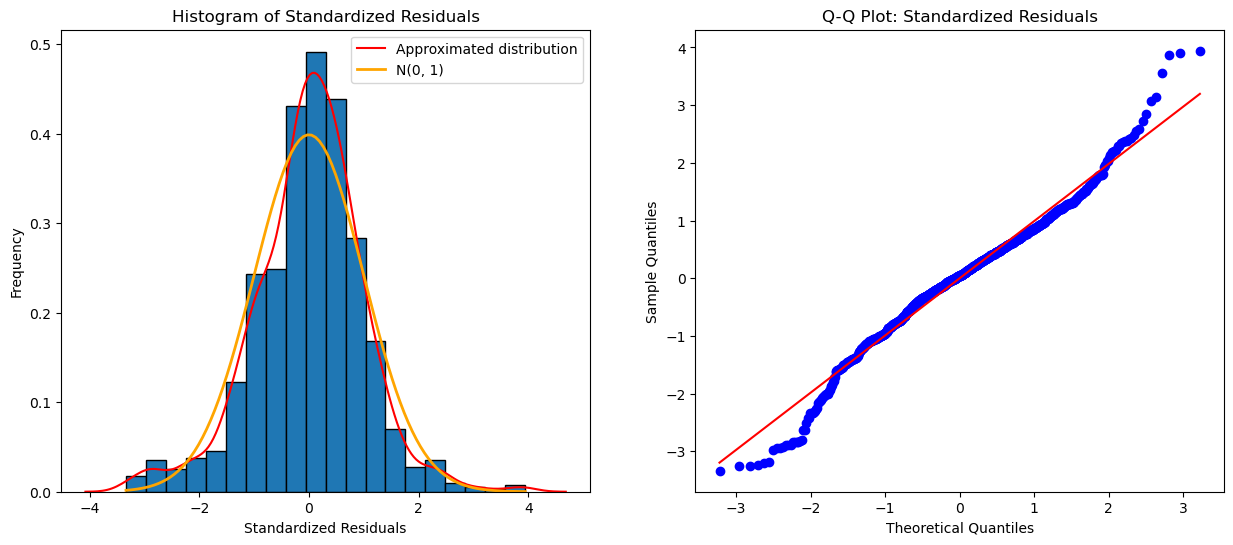

In [30]:
# Set up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].hist(s_residual, bins=20, edgecolor='k', density=True)
sns.kdeplot(s_residual, color='red', label="Approximated distribution", ax=ax[0])
x_range = np.linspace(np.min(s_residual), np.max(s_residual), 100)
value = stats.norm.pdf(x_range)
ax[0].plot(x_range, value, lw=2, color='orange', label='N(0, 1)')
ax[0].set_title('Histogram of Standardized Residuals')
ax[0].set_xlabel('Standardized Residuals')
ax[0].set_ylabel('Frequency')
ax[0].legend()

# Plot the QQ-plot (Normal probability plot)
stats.probplot(s_residual, plot=ax[1])
ax[1].set_title('Q-Q Plot: Standardized Residuals')
ax[1].set_xlabel('Theoretical Quantiles')
ax[1].set_ylabel('Sample Quantiles')

### Autocorrelation function (Correlogram)


Plot the Correlogram(in Lecture note #3, p.36) using `plot_acf` in statsmodels.

Input the residual and put the number of lags you want check.

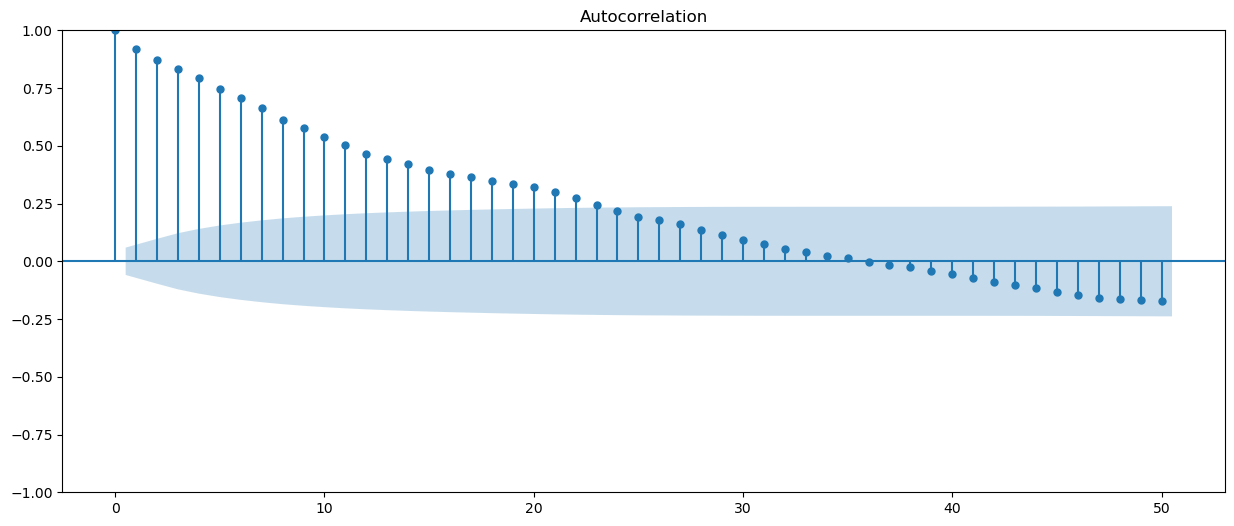

In [31]:
fig, ax = plt.subplots(figsize=(15, 6))
sm.graphics.tsa.plot_acf(s_residual, lags=50, ax=ax)
plt.show()

### Trend Regression MSE

In [32]:
curve_reg.mse_resid

0.08297464655124298